## Лабораторная работа по курсу "Искусственный интеллект"
## Многослойный персептрон

| Студент | Кузьмичев|
|---------|--------|
| Группа  | 6      |

Для начала, скачаем датасет MNIST. Используйте `wget` или `curl`, либо скачайте вручную [по ссылке](https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz).

In [1]:
#!wget https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz
!curl -o mnist.pkl.gz https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz
!gzip -d mnist.pkl.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9.9M  100  9.9M    0     0  27.3M      0 --:--:-- --:--:-- --:--:-- 27.3M


Теперь загружаем датасет и прописываем импорты:

In [ ]:
import pickle
import sys
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import gridspec
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
import random
from sklearn.model_selection import train_test_split
np.random.seed(0)
with open('mnist.pkl','rb') as f:
    MNIST = pickle.load(f)

In [ ]:
labels = MNIST['Train']['Labels']
data = MNIST['Train']['Features']

Смотрим на то, какие данные получились:

In [ ]:
data.shape

(42000, 784)

Используйте Scikit Learn для разбиения данных на обучающую и тестовую выборку, нормализуем выборку


In [ ]:
x_train, x_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.20)
x_test = x_test/255
x_train = x_train/255

Объявим классы для слоев персептрона:

1.   Linear
2.   SoftMax
3.   CrossEntropyLoss






In [ ]:
class Linear:
    def __init__(self,nin,nout):
        self.W = np.random.normal(0, 1.0/np.sqrt(nin), (nout, nin))
        self.b = np.zeros((1,nout))
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
        
    def forward(self, x):
        self.x=x
        return np.dot(x, self.W.T) + self.b
    
    def backward(self, dz):
        dx = np.dot(dz, self.W)
        dW = np.dot(dz.T, self.x)
        db = dz.sum(axis=0)
        self.dW = dW
        self.db = db
        return dx
    
    def update(self,lr):
        self.W -= lr*self.dW
        self.b -= lr*self.db


class Softmax:
    def forward(self,z):
        self.z = z
        zmax = z.max(axis=1,keepdims=True)
        expz = np.exp(z-zmax)
        Z = expz.sum(axis=1,keepdims=True)
        return expz / Z
    def backward(self,dp):
        p = self.forward(self.z)
        pdp = p * dp
        return pdp - p * pdp.sum(axis=1, keepdims=True)
    
class CrossEntropyLoss:
    def forward(self,p,y):
        self.p = p
        self.y = y
        p_of_y = p[np.arange(len(y)), y]
        log_prob = np.log(p_of_y)
        return -log_prob.mean()
    def backward(self,loss):
        dlog_softmax = np.zeros_like(self.p)
        dlog_softmax[np.arange(len(self.y)), self.y] -= 1.0/len(self.y)
        return dlog_softmax / self.p
        
class Tanh:
    def forward(self,x):
        y = np.tanh(x)
        self.y = y
        return y
    def backward(self,dy):
        return (1.0-self.y**2)*dy

Для удобства опишем класс, который позволяет объединять узлы вычислительного графа в единую сеть, и применять функции *forward* и *backward* сразу ко всей сети последовательно:



In [ ]:
class Net:
    def __init__(self):
        self.layers = []
    
    def add(self,l):
        self.layers.append(l)

    def addCrossEntropy(self, crossEntropy):
        self.crossEntropy = crossEntropy 
        
    def forward(self,x, y):
        for layer in self.layers:
            x = layer.forward(x)
        l = self.crossEntropy.forward(x,y)
        return l
    
    def backward(self,z):
        z = self.crossEntropy.backward(z)
        for l in self.layers[::-1]:
            z = l.backward(z)
        return z
    
    def forward_without_cross(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def update(self,lr):
        for l in self.layers:
            if 'update' in l.__dir__():
                l.update(lr)


Создадим класс, который будет отвечать за обучение нейронной сети. В нем будут методы для обучения нейронной сети, для показа результатов обучения. Так как мы пишем фреймворк, то человек сможет выбрать, нужен ему график или нет, а также загрузить свою нейронную сеть и свою обучающую выборку

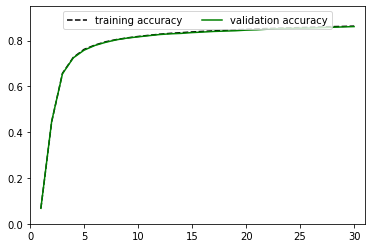

In [ ]:
import matplotlib.cm as cm

class Analyzer:

    def __init__(self):
        self.count_confusion = True
        self.confusion_pred = []
        self.confusion_true = []

    def get_loss_acc(self, net, x,y,loss=CrossEntropyLoss(), is_test = False):
        p = net.forward_without_cross(x)
        l = loss.forward(p,y)
        pred = np.argmax(p,axis=1)
        acc = (pred==y).mean()
        if (is_test == True):
            self.confusion_pred = []
            self.confusion_true = []
            self.confusion_pred+=pred.tolist()
            self.confusion_true+=y.tolist()
        return l,acc

class Teacher:

    def __init__(self, n_classes, x_train, labels_train, x_test, labels_test, analyzer):
        self.n_classes = n_classes
        self.x_train = x_train
        self.labels_train = labels_train
        self.x_test = x_test
        self.labels_test = labels_test
        self.analyzer = analyzer

    def train_epoch(self, net, train_x, train_labels, loss=CrossEntropyLoss(), batch_size=4, lr=0.1):
        for i in range(0,len(train_x),batch_size):
            xb = train_x[i:i+batch_size]
            yb = train_labels[i:i+batch_size]
            l = net.forward(xb, yb)
            dx = net.backward(l)
            net.update(lr)

        # generate countour grid

    def train_and_plot(self, n_epoch, net, loss=CrossEntropyLoss(), batch_size=4, lr=0.1, need_plot = True):
        net.addCrossEntropy(loss)
        fig, ax = plt.subplots(1, 1)
        ax.set_xlim(0, n_epoch + 1)
        ax.set_ylim(0,1)
        train_acc = np.empty((n_epoch, 3))
        train_acc[:] = np.NAN
        valid_acc = np.empty((n_epoch, 3))
        valid_acc[:] = np.NAN
    
        for epoch in range(1, n_epoch + 1):

            tloss, taccuracy = self.analyzer.get_loss_acc(net, self.x_train,self.labels_train,loss)
            train_acc[epoch-1, :] = [epoch, tloss, taccuracy]
            vloss, vaccuracy = self.analyzer.get_loss_acc(net, self.x_test, self.labels_test,loss, True)
            valid_acc[epoch-1, :] = [epoch, vloss, vaccuracy]
        
            ax.set_ylim(0, max(max(train_acc[:, 2]), max(valid_acc[:, 2])) * 1.1)
            if (need_plot):
                plot_training_progress(train_acc[:, 0], (train_acc[:, 2],
                                                 valid_acc[:, 2]), fig, ax)
                fig.canvas.draw()
                fig.canvas.flush_events()
            self.train_epoch(net, self.x_train,self.labels_train,loss,batch_size,lr)


        return train_acc, valid_acc

    def plot_training_progress(self, x, y_data, fig, ax):
        styles = ['k--', 'g-']
        # remove previous plot
        while ax.lines:
            ax.lines.pop()
        # draw updated lines
        for i in range(len(y_data)):
            ax.plot(x, y_data[i], styles[i])
        ax.legend(ax.lines, ['training accuracy', 'validation accuracy'],
              loc='upper center', ncol = 2)

net = Net()
analyzer = Analyzer()
teacher = Teacher(n_classes = 10, x_train=x_train, labels_train = labels_train, x_test = x_test, labels_test = labels_test, analyzer = analyzer)
net.add(Linear(28*28,10))
net.add(Softmax())
res = teacher.train_and_plot(30, net, CrossEntropyLoss(), lr = 0.00005, need_plot = True)


Теперь выведем Confusion Matrix с помощью SKLearn, с помощью нее можно увидеть частоту ложных и верных предсказаний по классам

In [ ]:
analyzer.get_loss_acc(net, x_test, labels_test,net.crossEntropy, True)
print(confusion_matrix(analyzer.confusion_true, analyzer.confusion_pred))

[[776   0   1   3   3   7  11   2  11   2]
 [  0 907   7   4   0   5   1   0  31   1]
 [ 16  10 682  18  19   0  31  18  33   7]
 [  6   4  23 719   0  29  16  18  22  14]
 [  2  16   8   1 647   0   7   5   9  80]
 [ 17  18   4  47  18 570  18   4  42  12]
 [ 10   5  13   2   7  12 807   0   9   0]
 [  3  18  15   2  12   1   1 771   4  42]
 [  6  33  11  42   4  33   9   7 642  27]
 [ 10  14   6  15  50   3   1  38   8 725]]


Теперь попробуем сделать анализ обучения для набора датасета FashionMnist, который считается более новым. Для этого загрузим данные, создадим нейронную сеть и построим график



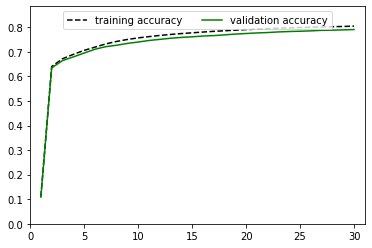

In [ ]:
import tensorflow as tf
import numpy as np
import os

import distutils

(x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion__test) = tf.keras.datasets.fashion_mnist.load_data()
x_fashion_train = x_fashion_train/ 255.0
x_fashion_test = x_fashion_test/ 255.0
num_pixels = 784
x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0],
                         num_pixels)
x_fashion_test = x_fashion_test.reshape(x_fashion_test.shape[0],
                         num_pixels)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


net = Net()
net.add(Linear(28*28,10))
net.add(Softmax())
analyzer = Analyzer()
teacher = Teacher(n_classes = 10, x_train=x_fashion_train, labels_train = y_fashion_train, x_test = x_fashion_test, labels_test = y_fashion__test, analyzer = analyzer)
res = teacher.train_and_plot(30, net, CrossEntropyLoss(), lr = 0.00005, need_plot = True)


Для начала загрузим данные и покажем, что представляет из себя выборка FashionMnist

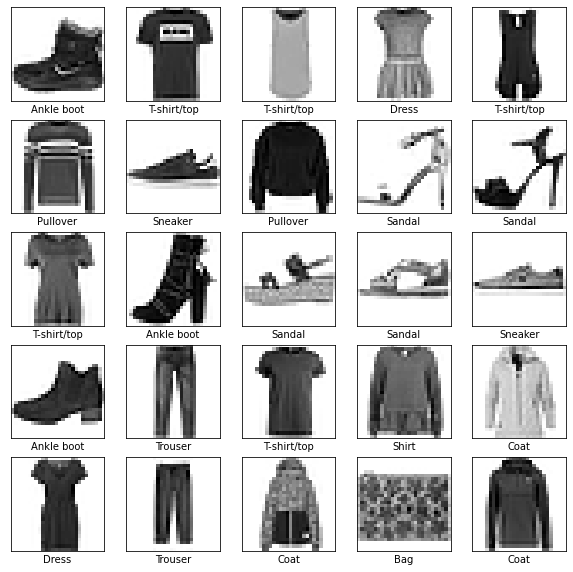

In [ ]:
import tensorflow as tf
import numpy as np
import os

import distutils

(x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion__test) = tf.keras.datasets.fashion_mnist.load_data()
x_fashion_train = x_fashion_train/ 255.0
x_fashion_test = x_fashion_test/ 255.0
num_pixels = 784

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
               
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_fashion_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_fashion_train[i]])
plt.show()

Как мы видим, размер картинок не изменился - это все те же черно-белые изображения, но теперь тут разные элементы одежды. Для начала преобразуем матрицы пикселей в вектора, затем создадим нейронную сеть и обучим ее на тестовой выборке. Построим график обучения

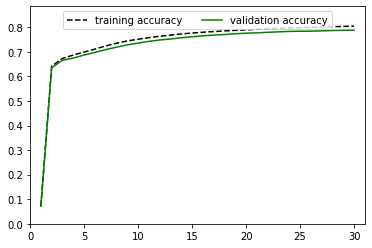

In [ ]:
num_pixels = 784
x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0],
                         num_pixels)
x_fashion_test = x_fashion_test.reshape(x_fashion_test.shape[0],
                         num_pixels)
net = Net()
net.add(Linear(28*28,10))
net.add(Softmax())
analyzer = Analyzer()
teacher = Teacher(n_classes = 10, x_train=x_fashion_train, labels_train = y_fashion_train, x_test = x_fashion_test, labels_test = y_fashion__test, analyzer = analyzer)
res = teacher.train_and_plot(30, net, CrossEntropyLoss(), lr = 0.00005, need_plot = True)

Мы видим, что для этой выборки validation accuracy не такая высокая, как для обычной MNIST. В MNIST оно больше 85 процентов, тут же держится около 80. Также и для этой выборки выведем Confusion Matrix

In [ ]:
analyzer.get_loss_acc(net, x_fashion_test, y_fashion__test,net.crossEntropy, True)
print(confusion_matrix(analyzer.confusion_true, analyzer.confusion_pred))

[[793   7  17  75   6   1  78   0  22   1]
 [  7 925  16  40   9   0   1   0   2   0]
 [ 22   0 659   9 212   1  80   0  17   0]
 [ 37  13   8 848  37   1  51   0   5   0]
 [  0   2 112  47 767   0  66   0   6   0]
 [  1   0   0   3   0 746   0 148  10  92]
 [196   3 138  50 157   1 415   0  40   0]
 [  0   0   0   0   0  33   0 881   0  86]
 [  1   1  16  15   3   3  19  11 929   2]
 [  0   0   0   0   0  12   0  56   1 931]]


В данной лабораторной работе я познакомился с базовой архитектурой многослойного персептрона, математическим аппаратом, на котором работает нейронная сеть. Эта работа была полезной для более глубокого понимания темы, однако каждый раз писать свою реализацию нейронной сети не имеет смысла, потому что это может быть затратно и уже есть готовые реализации нейросетей.